In [ ]:
#Unzipping the folders
!unzip "drive/MyDrive/Colab Notebooks/BTCUSDT_OHLC.zip"

Archive:  drive/MyDrive/Colab Notebooks/BTCUSDT_OHLC.zip
  inflating: BTCUSDT-1m-2023-11.csv  


In [ ]:
!unzip "drive/MyDrive/Colab Notebooks/BTCUSDT_aggTrades.zip"

Archive:  drive/MyDrive/Colab Notebooks/BTCUSDT_aggTrades.zip
  inflating: BTCUSDT-aggTrades-2023-11.csv  


In [ ]:
#Importing Necessary Libraries
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

*Reading the unzipped files and finding out the size and column names using pandas*




In [ ]:
df = pd.read_csv("BTCUSDT-1m-2023-11.csv")
print(df.head(5))

       open_time     open     high      low    close   volume     close_time  \
0  1698796800000  34651.4  34676.5  34650.0  34669.9  376.040  1698796859999   
1  1698796860000  34669.9  34684.0  34637.3  34637.4  431.177  1698796919999   
2  1698796920000  34637.4  34653.4  34632.5  34651.4  175.894  1698796979999   
3  1698796980000  34651.3  34651.4  34608.6  34621.1  476.587  1698797039999   
4  1698797040000  34621.1  34622.6  34592.0  34615.4  546.312  1698797099999   

   quote_volume  count  taker_buy_volume  taker_buy_quote_volume  ignore  
0  1.303610e+07   4214           199.885            6.929501e+06       0  
1  1.494828e+07   4495           229.490            7.957308e+06       0  
2  6.093655e+06   2669            71.494            2.476893e+06       0  
3  1.650097e+07   5182            89.613            3.102759e+06       0  
4  1.890390e+07   5557           214.962            7.438203e+06       0  


**Defining all necessary functions**

In [ ]:
#function to calculate Relative strength Index
def rsi(DF, n=15):
    df = DF.copy()
    df["change"] = df["close"] - df["close"].shift(1)
    df["gain"] = np.where(df["change"]>=0, df["change"], 0)
    df["loss"] = np.where(df["change"]<0, -1*df["change"], 0)
    df["avgGain"] = df["gain"].ewm(alpha=1/n, min_periods=n).mean()
    df["avgLoss"] = df["loss"].ewm(alpha=1/n, min_periods=n).mean()
    df["rs"] = df["avgGain"]/df["avgLoss"]
    df["rsi"] = 100 - (100/ (1 + df["rs"]))
    return df["rsi"]

In [ ]:
#function to calculate Bollinger Band
def BB(df, n=14):
    DF = df.copy()
    DF["MB"]= DF["close"].rolling(n).mean()
    DF["UB"] = DF["MB"] + 2*DF["close"].rolling(n).std(ddof=0)
    DF["LB"] = DF["MB"] - 2*DF["close"].rolling(n).std(ddof=0)
    return DF[["UB","LB"]]

In [ ]:
#function to calculate Average True Range
def ATR(DF,n):
    df = DF.copy()
    df['H-L']=abs(df['high']-df['low'])
    df['H-PC']=abs(df['high']-df['close'].shift(1))
    df['L-PC']=abs(df['low']-df['close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    # df['ATR'] = df['TR'].rolling(n).mean()
    df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    return df['ATR']

In [ ]:
def volatility(DF):
    vol = DF["ret"].std()*100
    return vol
def max_dd(DF):
    #function to calculate the max drawdown
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()*100
    return max_dd

In [ ]:
#df = df.drop(columns=["close_time","quote_volume","count","taker_buy_volume","taker_buy_quote_volume","ignore"])
df['open_time']=pd.to_datetime(df['open_time'],unit='ms')
df['target_val'] = df.close - df.open
df['target_val'] = df['target_val'].shift(-1)
df['target'] = [1 if df.target_val[i]>0 else 0 for i in range(len(df))]
df['target_nxt_close'] = df['close'].shift(-1)
df["EMAM"] = df["close"].ewm(span=100, min_periods=100).mean()
df["EMAF"] = df["close"].ewm(span=20, min_periods=20).mean()
df["EMAS"] = df["close"].ewm(span=150, min_periods=150).mean()
df["volume_10ma"] = df["volume"].ewm(span=10, min_periods=10).mean()
df["volume_30ma"] = df["volume"].ewm(span=30, min_periods=30).mean()
df["RSI"]=rsi(df)
df[["UB","LB"]]=BB(df)
df["ATR"]=ATR(df,15)
df["price"]=df["open"].shift(-1)
df.dropna(inplace=True)
df.reset_index(inplace=True)

**Model 1: Predicting price movement direction using Random Forest Classifier**

Target column is created such that it has 1 for price rise and -1 for price fall, I'm trying to create a model using Random Forest Classifier (as it is a type of binary classification problem) to predict the price movement direction. I've added RSI, 7-period rolling average of close and target to the dataframe, as it can improve the classification model (because they closely follow the trends and can be a good indicator). I've split the data into first 80% train data and next 20% test data, using random split is meaningless as we always want the model to learn about past events and predict future values.

In [ ]:
df = df.dropna()
total_rows = df.shape[0]
split_index = int(0.8 * total_rows)
train_df = df[:split_index]
test_df = df[split_index:]
features = ['open', 'high', 'low', 'close', 'volume','EMAF','Anomaly'] #Using necessary inputs to the model
target = 'target'
model = RandomForestClassifier(n_estimators=50, random_state=42)
model.fit(train_df[features], train_df[target])

RandomForestClassifier(n_estimators=50, random_state=42)

After creating the model, I've tested the model and calculated it's metrics such as Accuracy, Precision, Recall and F1 Score. I've also created a confusion matrix to analyze the result. The results shows it was accurate in predicting for roughly about 51% of the time, the average accuracy for a machine learning model in price prediction is 50% which just implies mere guessing, even after several testing with different data sets it gives roughly 1% more than that, which might be because of contributions from Anomalies and moving avg.

In [ ]:
preds = model.predict(test_df[features])
conf_matrix = confusion_matrix(test_df[target], preds)
accuracy = accuracy_score(test_df[target], preds)
precision = precision_score(test_df[target], preds)
recall = recall_score(test_df[target], preds)
f1 = f1_score(test_df[target], preds)
print("Confusion Matrix:")
#[1][1] gives number of values correctly predicted as rise,
#[1][2] gives number of values incorrectly predicted as rise,
#[2][1] gives number of values incorrectly predicted as fall,
#[2][2] gives number of values correctly predicted as fall,
print(conf_matrix)
print("Accuracy:", accuracy*100)
print("Precision:", precision*100)
print("Recall:", recall*100)
print("F1 Score:", f1*100)

Confusion Matrix:
[[2638 1852]
 [2371 1756]]
Accuracy: 50.99222467215968
Precision: 48.669623059866964
Recall: 42.549067118972616
F1 Score: 45.40400775694893


The above confusion matrix shows the model managed to predict price rise much better that price fall. This might be because the model managed to learn about price rise from the past events than the fall.

**Model 2:** Using RNN and LSTM

In [ ]:
features = ['open', 'high', 'low', 'close', 'volume','EMAF','EMAM','EMAS','RSI','target_val','target','target_nxt_close']
data_set = df[features]
sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(data_set)
print(scaled_data)

[[0.08309826 0.07784087 0.09644587 ... 0.47598513 1.         0.08495887]
 [0.0825811  0.079657   0.09585821 ... 0.46877323 1.         0.08507638]
 [0.08497884 0.07974896 0.098867   ... 0.47026022 1.         0.08564042]
 ...
 [0.83768218 0.81578887 0.85092379 ... 0.46542751 0.         0.8359342 ]
 [0.83707099 0.81519115 0.84993653 ... 0.47286245 1.         0.8373208 ]
 [0.83610719 0.81558197 0.84993653 ... 0.48267658 1.         0.84178613]]


In [ ]:
input=[]
back_candles = 30
for j in range(9):
  input.append([])
  for i in range(back_candles,scaled_data.shape[0]):
    input[j].append(scaled_data[i-back_candles:i,j])
input = np.moveaxis(input, [0], [2])
input, y = np.array(input), np.array(scaled_data[back_candles:,-1])
target = np.reshape(y, (len(y), 1))
print(input.shape, target.shape)

(43020, 30, 9) (43020, 1)


In [ ]:
split = int(len(input)*0.8)
X_train , X_test = input[:split], input[split:]
Y_train , Y_test = target[:split], target[split:]

In [ ]:
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History,EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

In [ ]:
lstm_input = Input(shape = (back_candles,9), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam_optimizer = optimizers.Adam(learning_rate=0.01)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.compile(optimizer = adam_optimizer, loss='mse')
model.fit(x=X_train, y=Y_train, batch_size=32, epochs=30, shuffle=True, validation_split=0.1, callbacks=[early_stop])

Epoch 1/30
968/968 [==============================] - 49s 49ms/step - loss: 0.0171 - val_loss: 4.3421e-04
Epoch 2/30
968/968 [==============================] - 44s 45ms/step - loss: 4.9538e-04 - val_loss: 2.3060e-04
Epoch 3/30
968/968 [==============================] - 45s 46ms/step - loss: 5.0045e-04 - val_loss: 1.6923e-04
Epoch 4/30
968/968 [==============================] - 47s 48ms/step - loss: 4.8392e-04 - val_loss: 9.1311e-05
Epoch 5/30
968/968 [==============================] - 52s 53ms/step - loss: 5.3449e-04 - val_loss: 1.8276e-04
Epoch 6/30
968/968 [==============================] - 47s 48ms/step - loss: 5.0024e-04 - val_loss: 2.0426e-04
Epoch 7/30
968/968 [==============================] - 41s 42ms/step - loss: 4.7252e-04 - val_loss: 1.1377e-04
Epoch 8/30
968/968 [==============================] - 44s 45ms/step - loss: 4.0296e-04 - val_loss: 2.6581e-04
Epoch 9/30
968/968 [==============================] - 44s 45ms/step - loss: 4.1255e-04 - val_loss: 3.2749e-04
Epoch 10/30
96

In [ ]:
Y_pred = model.predict(X_test)

269/269 [==============================] - 8s 30ms/step


Mean squared Error: 20445.2996


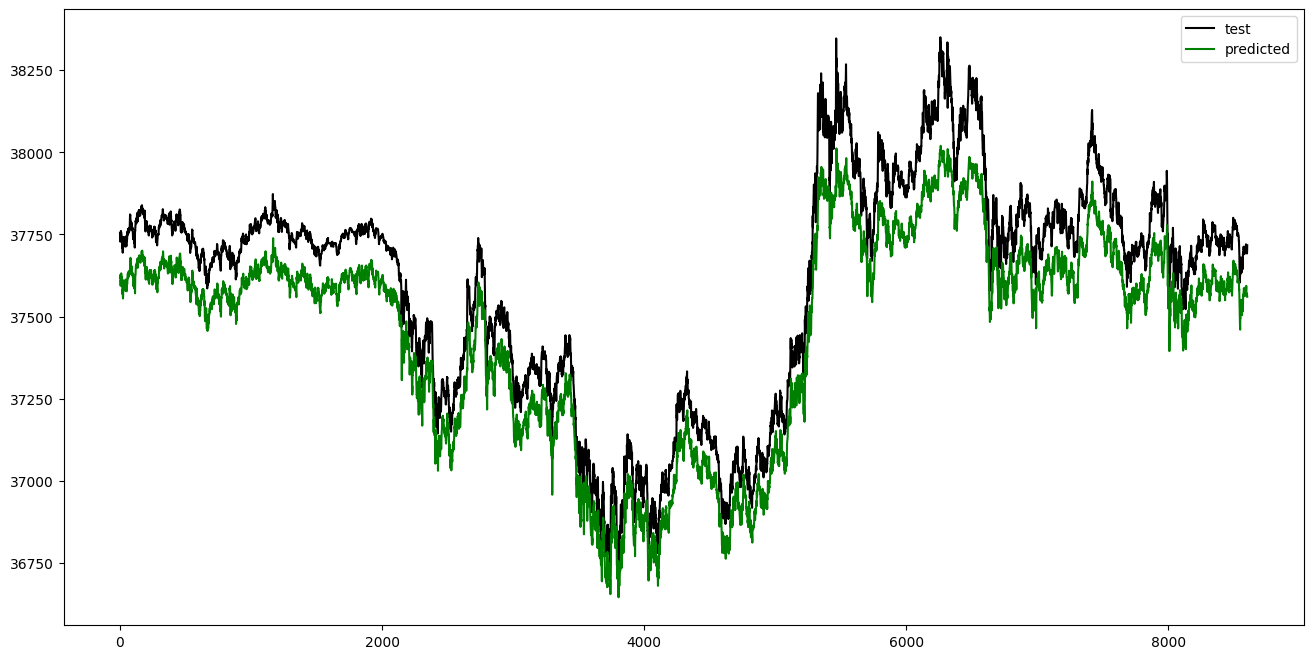

In [ ]:
#FOR INVERSE TRANSFORMATION
sc = MinMaxScaler()
arr = np.array(df['target_nxt_close']).reshape(-1, 1)
samp= sc.fit_transform(arr)
pred_data = sc.inverse_transform(Y_pred)
org_data = sc.inverse_transform(Y_test)
mse = mean_squared_error(org_data, pred_data)
print('Mean squared Error: {:.4f}'.format(mse))
plt.figure(figsize=(16,8))
plt.plot(org_data, color='black',label='test')
plt.plot(pred_data, color='green',label='predicted')
plt.legend()
plt.show()

From the above graph we can see the model managed to predict the trends pretty decently and didn't overfit the data, but still has a resonable error. But this is comparatively better than the previous one as it managed to capture the trend and give us a better intution about the price movement

**Detecting Anomaly in Price change**

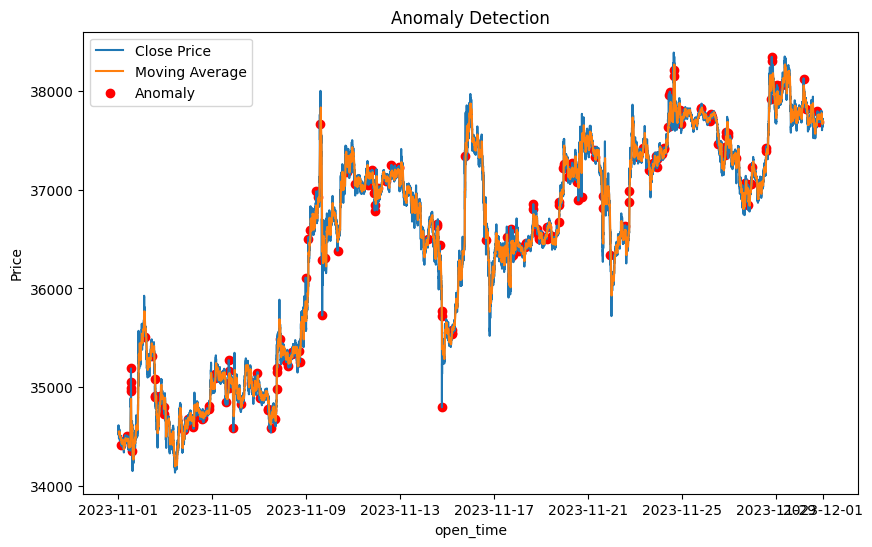

In [ ]:
df['std'] = df['close'].rolling(window=26).std()
threshold = 3
# Identify anomalies based on the distance of closing prices from the moving average
df['Anomaly'] = (df['close'] - df['slow_ema']).abs() > threshold * df['std']
# Plot the data with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.plot(df['open_time'], df['close'], label='Close Price')
plt.plot(df['open_time'], df['slow_ema'], label='Moving Average')
plt.scatter(df[df['Anomaly']]['open_time'], df[df['Anomaly']]['close'], color='red', label='Anomaly')
plt.title('Anomaly Detection')
plt.xlabel('open_time')
plt.ylabel('Price')
plt.legend()
plt.show()

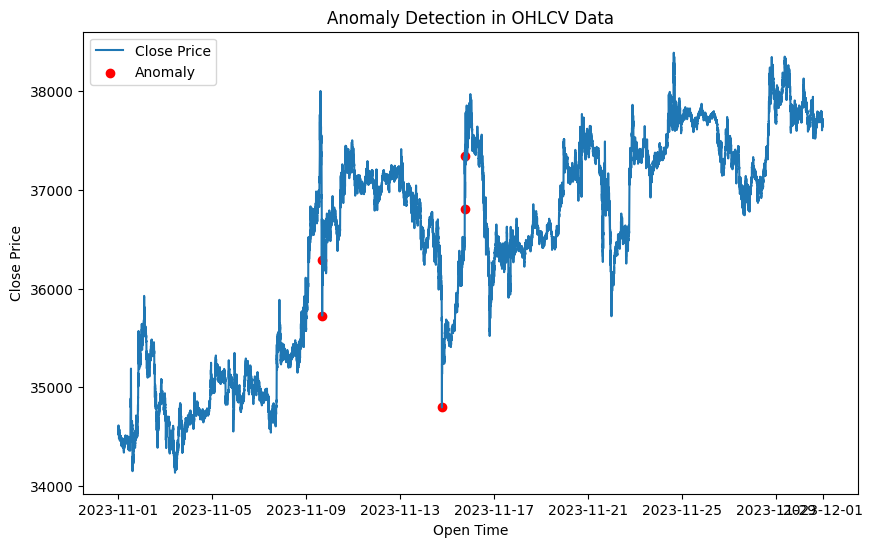

In [ ]:
df['Price Change'] = df['close'].pct_change()
threshold = 0.01
df['Anomaly'] = abs(df['Price Change']) > threshold
plt.figure(figsize=(10, 6))
plt.plot(df['open_time'], df['close'], label='Close Price')
plt.scatter(df[df['Anomaly']]['open_time'], df[df['Anomaly']]['close'], color='red', label='Anomaly')
plt.title('Anomaly Detection')
plt.xlabel('Open Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
df2 = pd.read_csv("BTCUSDT-aggTrades-2023-11.csv")
df2['transact_time']=pd.to_datetime(df2['transact_time'],unit='ms')
df2.set_index('transact_time',inplace=True)
print(df2.head(5))

                         agg_trade_id    price  quantity  first_trade_id  \
transact_time                                                              
2023-11-01 00:00:05.027    1900987669  34651.4     0.258      4244484021   
2023-11-01 00:00:05.055    1900987670  34651.3     0.001      4244484029   
2023-11-01 00:00:05.056    1900987671  34651.4     0.007      4244484030   
2023-11-01 00:00:05.061    1900987672  34651.3     0.361      4244484032   
2023-11-01 00:00:05.076    1900987673  34651.4     0.007      4244484035   

                         last_trade_id  is_buyer_maker  
transact_time                                           
2023-11-01 00:00:05.027     4244484028           False  
2023-11-01 00:00:05.055     4244484029            True  
2023-11-01 00:00:05.056     4244484031           False  
2023-11-01 00:00:05.061     4244484034            True  
2023-11-01 00:00:05.076     4244484037           False  


**Strategy-1: Using BB and MA**

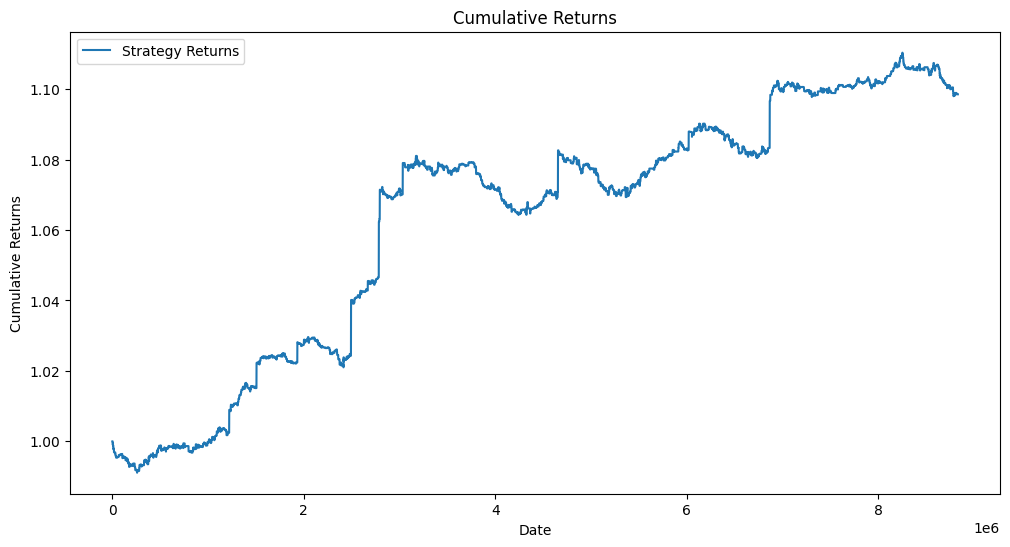

In [ ]:
def bar(x, y):
    return np.int64(x / y) * y
traded_volume = 100
volume_bars = df2.groupby(bar(np.cumsum(df2['quantity']), traded_volume)).agg({'price': 'ohlc', 'quantity': 'sum'})
close_prices = volume_bars['price']['close']
sma = close_prices.rolling(window=12).mean()
std_dev = close_prices.rolling(window=12).std()
upper_band = sma + 2 * std_dev
lower_band = sma - 2 * std_dev
Short_MA = close_prices.ewm(span=9, adjust=False).mean()
Long_MA = close_prices.ewm(span=26, adjust=False).mean()
signals = pd.Series(index=close_prices.index, data=0)
signals[(close_prices < lower_band) & (Short_MA > Long_MA)] = 1
signals[(close_prices > upper_band) & (Short_MA < Long_MA)] = -1
# Calculate daily log returns
returns = np.log(close_prices / close_prices.shift(1)).dropna()
strategy_returns = signals.shift(1) * returns
# Cumulative returns of the strategy
cumulative_returns = (1+strategy_returns).cumprod()
# Visualizing cumulative returns
plt.figure(figsize=(12, 6))
cumulative_returns.plot(label='Strategy Returns')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

**Strategy-2: Using RSI and ATR**

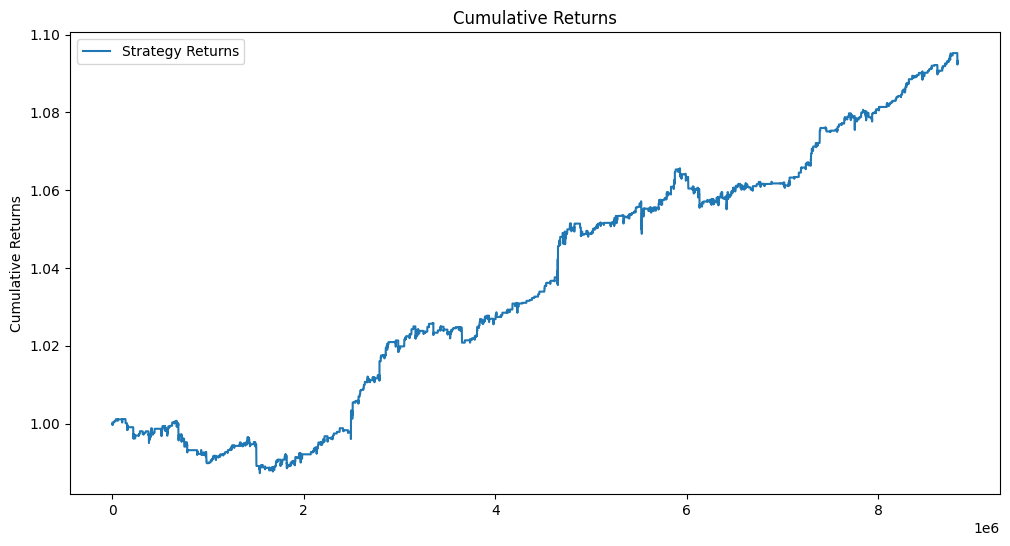

In [ ]:
atr = ATR(volume_bars['price'], 14)
RSI = rsi(volume_bars['price'], 14)
signals = pd.Series(index=close_prices.index, data=0)
#Buying when oversold and selling when overbought
signals[(RSI < 30) & (atr < atr.quantile(0.3))] = 1
signals[(RSI > 70) & (atr > atr.quantile(0.7))] = -1
strategy_returns = signals.shift(1) * returns
cumulative_returns = (1+strategy_returns).cumprod()
plt.figure(figsize=(12, 6))
cumulative_returns.plot(label='Strategy Returns')
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

**Strategy-3: Using MACD and ATR**

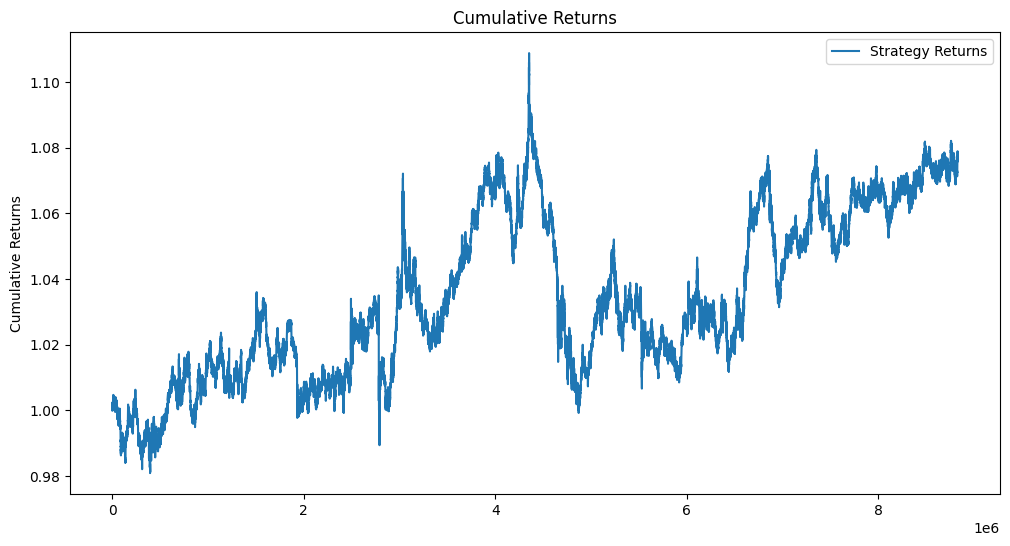

In [ ]:
MACD = Short_MA - Long_MA
Signal_Line = MACD.ewm(span=12, adjust=False).mean()
signals = pd.Series(index=close_prices.index, data=0)
signals[(MACD > Signal_Line) & (atr < atr.quantile(0.3))] = 1
signals[(MACD < Signal_Line) | (atr > atr.quantile(0.7))] = -1
strategy_returns = signals.shift(1) * returns
cumulative_returns = (1+strategy_returns).cumprod()
plt.figure(figsize=(12, 6))
cumulative_returns.plot(label='Strategy Returns')
plt.title('Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

The results shows this is a highly volatile strategy with high risk associated, when traded with caution (eg. with stop loss, reducing the frequency, combining other indicators) it can be highly profitable

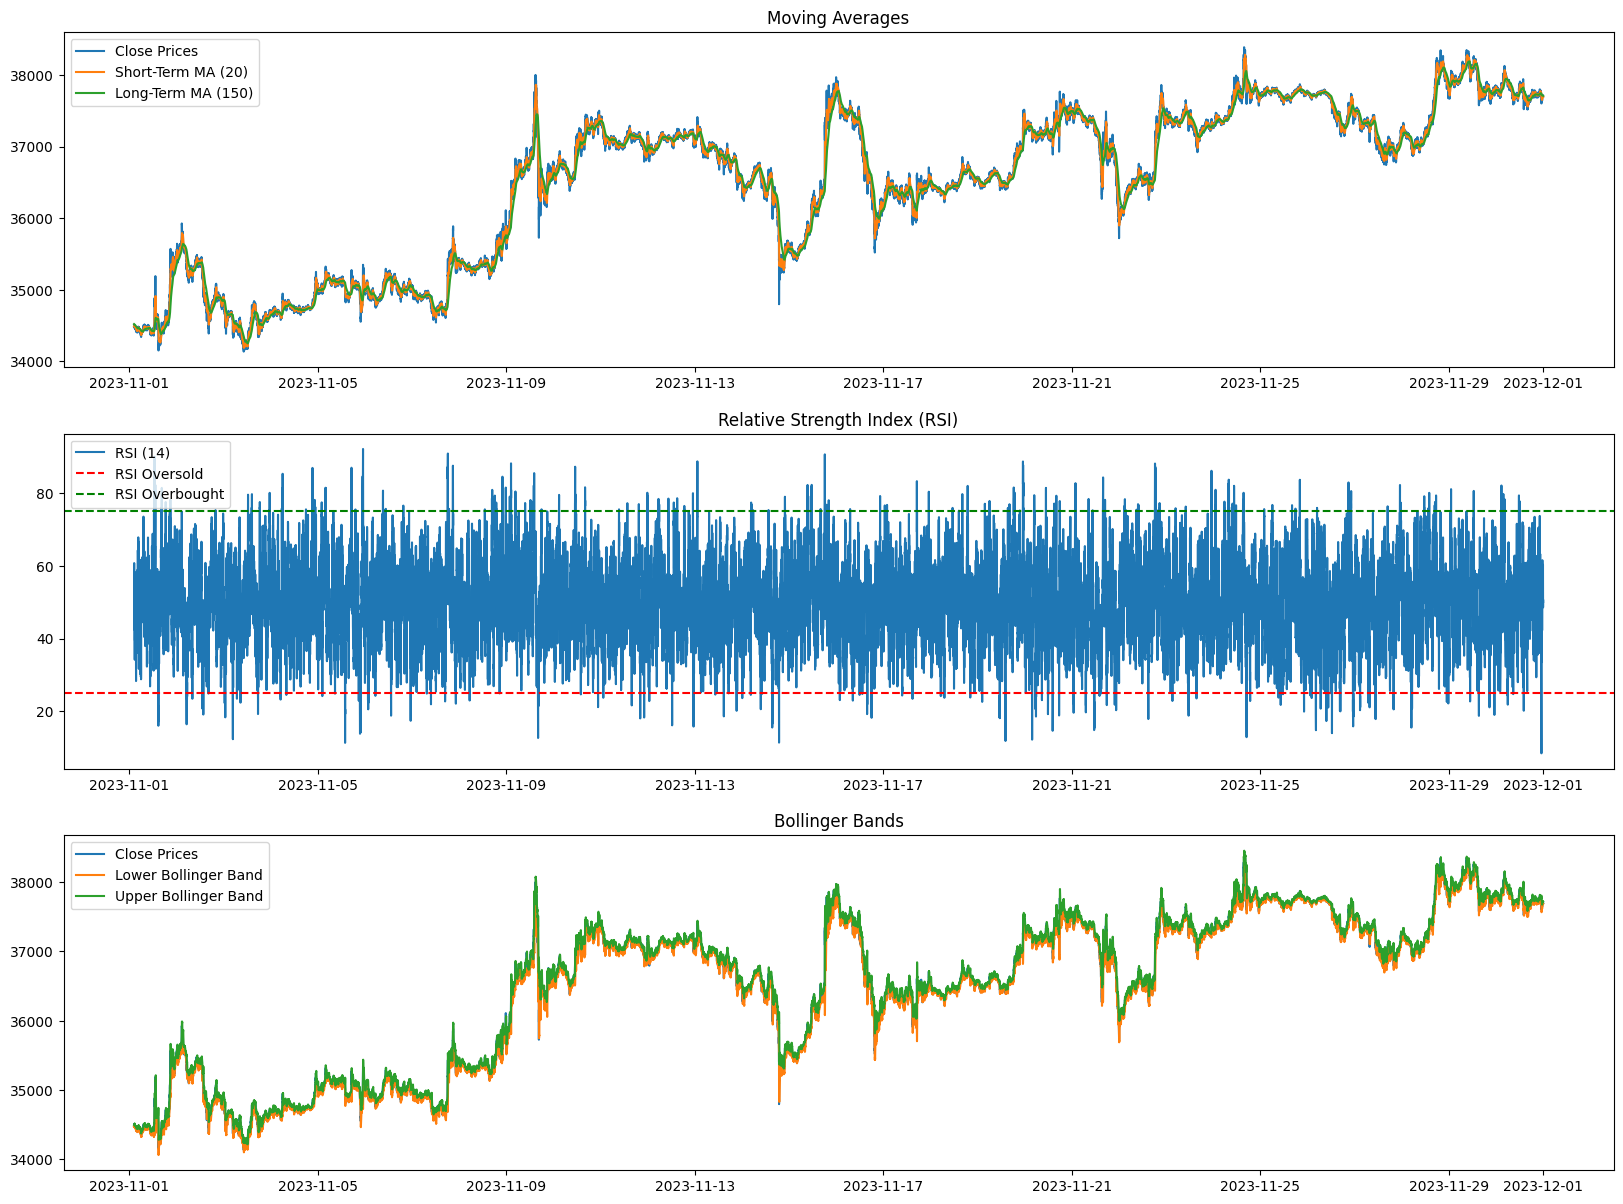

In [ ]:
# Visualizing the technical indiacators to have a better understanding on data
plt.figure(figsize=(20, 20))
plt.subplot(4, 1, 1)
plt.plot(df.open_time, df["close"], label='Close Prices')
plt.plot(df.open_time, df["EMAF"], label='Short-Term MA (20)')
plt.plot(df.open_time, df["EMAS"], label='Long-Term MA (150)')
plt.title('Moving Averages')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(df.open_time, df["RSI"], label='RSI (14)')
plt.axhline(25, color='r', linestyle='--', label='RSI Oversold')
plt.axhline(75, color='g', linestyle='--', label='RSI Overbought')
plt.title('Relative Strength Index (RSI)')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(df.open_time, df["close"], label='Close Prices')
plt.plot(df.open_time, df["LB"], label='Lower Bollinger Band')
plt.plot(df.open_time, df["UB"], label='Upper Bollinger Band')
plt.title('Bollinger Bands')
plt.legend()

plt.show()

**Trading Strategy-1 Using Bollinger Bands**

In [ ]:
# Strategy to generate Buy and sell signals
df = df.dropna()
df = df.reset_index(drop=True)
in_pos=False
buy_signal=[]
sell_signal=[]
profits=[]
for i in range(df.shape[0]):
    if df.iloc[i]["close"] < df.iloc[i]["LB"] and not in_pos:
        buy_price=df.iloc[i]["price"]
        buy_signal.append(df.iloc[i]["price"])
        sell_signal.append(float('nan'))
        in_pos=True
    elif (df.iloc[i]["close"] > df.iloc[i]["UB"] and in_pos):
        profits.append((df.iloc[i]["price"]-buy_price)/buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float('nan'))
        in_pos=False
    elif i==df.shape[0]-1 and in_pos:
        profits.append((df.iloc[i]["price"]-buy_price)/buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float('nan'))
        in_pos=False
    else:
        sell_signal.append(float('nan'))
        buy_signal.append(float('nan'))

The below graph shows this is a really good profitable strategy

No:of Trades: 545


<Axes: >

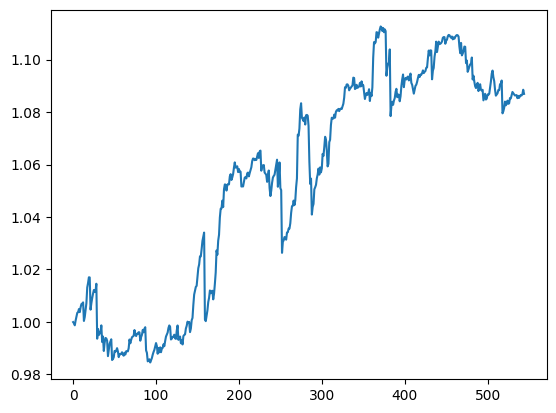

In [ ]:
print("No:of Trades:",len(profits))
(pd.Series(profits) +1).cumprod().plot(label='Cumulative Returns')

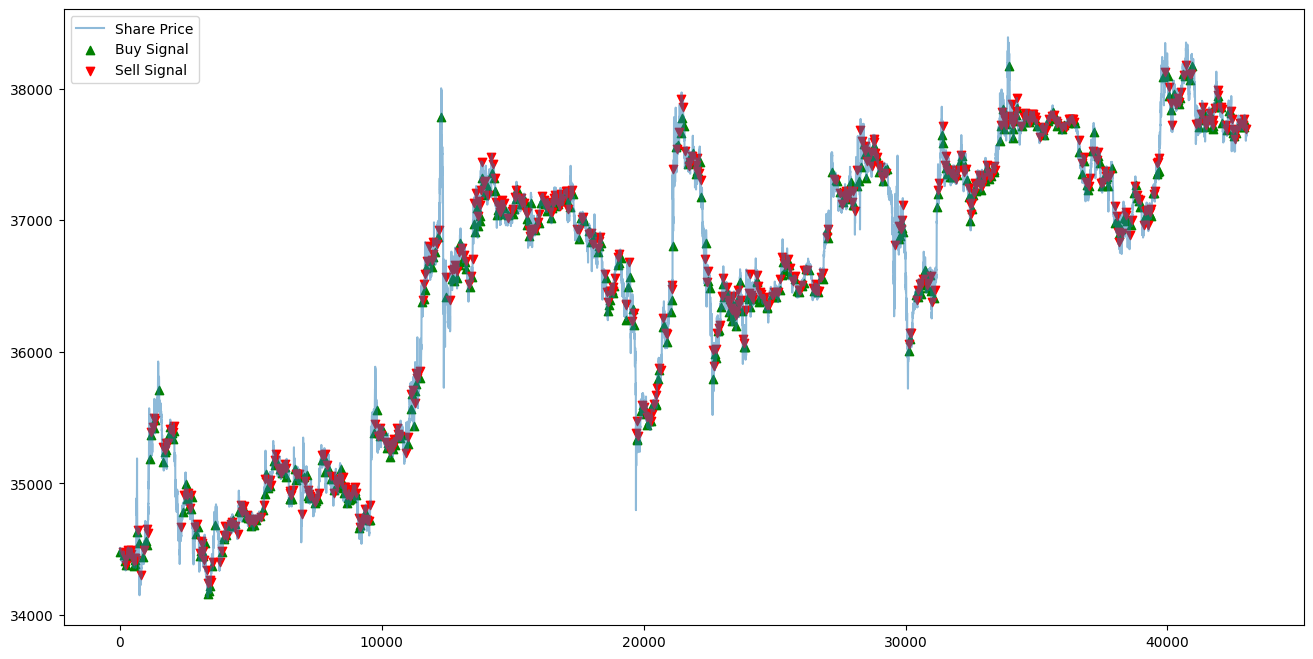

In [ ]:
plt.figure(figsize=(16,8))
df['buy_signal']=buy_signal
df['sell_signal']=sell_signal
plt.plot(df['close'],label='Share Price',alpha=0.75)
plt.scatter(df.index, df['buy_signal'], label='Buy Signal',  marker='^',color='green')
plt.scatter(df.index, df['sell_signal'], label='Sell Signal', marker='v',color='red')
plt.legend()
plt.show()

Analysing the returns and it's volatility

In [ ]:
profits = np.array(profits)
Winning_trades=sum(profit > 0 for profit in profits)
print("Total no:of Trades:", len(profits))
print("No:of Winning Trades:",Winning_trades )
print("No:of Losing Trades:", len(profits)-Winning_trades)
print("Success rate: {:.4f}%" .format(Winning_trades/len(profits)*100))
print("Cumulative Return: {:.4f}%" .format((np.prod(1 + profits) - 1)*100))
df_ret = pd.DataFrame({"ret": profits})
print("Volatility: {:.4f}%" .format(volatility(df_ret)))
print("Max Drawdown: {:.4f}%" .format(max_dd(df_ret)))

Total no:of Trades: 545
No:of Winning Trades: 354
No:of Losing Trades: 191
Success rate: 64.9541%
Cumulative Return: 8.6929%
Volatility: 0.3490%
Max Drawdown: 3.9175%


Trading with BB alone is a relatively low risk and good returns strategy just as the results show

**Trading Strategy-3 A combination of RSI, BB and Moving Averages**

No:of Trades: 275


<Axes: >

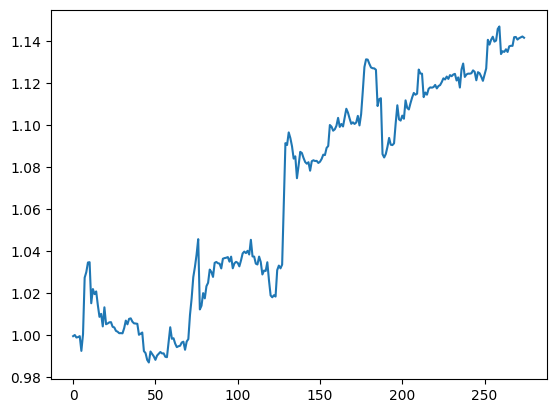

In [ ]:
# Strategy to generate Buy and sell signals
in_pos=False
buy_signal=[]
sell_signal=[]
profits=[]
for i in range(df.shape[0]):
    if (df.iloc[i]["RSI"] < 25 or (df.iloc[i]["close"] < df.iloc[i]["LB"] and df["EMAF"].iloc[i]>df["EMAS"].iloc[i])) and not in_pos:
        buy_price=df.iloc[i]["price"]
        buy_signal.append(df.iloc[i]["price"])
        sell_signal.append(float('nan'))
        in_pos=True
    elif (df.iloc[i]["RSI"] > 75 or (df.iloc[i]["close"] > df.iloc[i]["UB"] and df["EMAF"].iloc[i]<df["EMAS"].iloc[i])) and in_pos:
        profits.append((df.iloc[i]["price"]-buy_price)/buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float('nan'))
        in_pos=False
    elif i==df.shape[0]-1 and in_pos:
        profits.append((df.iloc[i]["price"]-buy_price)/buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float('nan'))
        in_pos=False
    else:
        sell_signal.append(float('nan'))
        buy_signal.append(float('nan'))
print("No:of Trades:",len(profits))
(pd.Series(profits) +1).cumprod().plot()

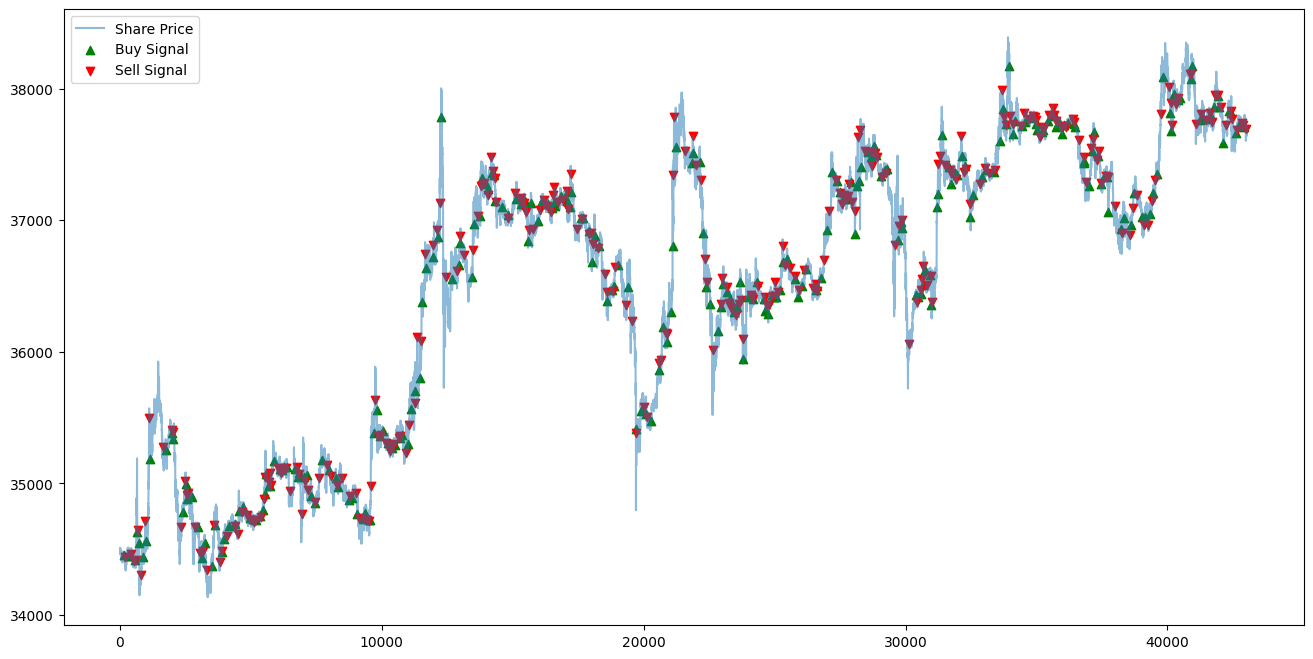

In [ ]:
plt.figure(figsize=(16,8))
df['buy_signal']=buy_signal
df['sell_signal']=sell_signal
plt.plot(df['close'],label='Share Price',alpha=0.5)
plt.scatter(df.index, df['buy_signal'], label='Buy Signal',  marker='^',color='green')
plt.scatter(df.index, df['sell_signal'], label='Sell Signal', marker='v',color='red')
plt.legend()
plt.show()

In [ ]:
profits = np.array(profits)
Winning_trades=sum(profit > 0 for profit in profits)
print("Total no:of Trades:", len(profits))
print("No:of Winning Trades:",Winning_trades )
print("No:of Losing Trades:", len(profits)-Winning_trades)
print("Success rate: {:.4f}%" .format(Winning_trades/len(profits)*100))
print("Cumulative Return: {:.4f}%" .format((np.prod(1 + profits) - 1)*100))
df_ret = pd.DataFrame({"ret": profits})
print("Volatility: {:.4f}%" .format(volatility(df_ret)))
print("Max Drawdown: {:.4f}%" .format(max_dd(df_ret)))

Total no:of Trades: 275
No:of Winning Trades: 150
No:of Losing Trades: 125
Success rate: 54.5455%
Cumulative Return: 14.1754%
Volatility: 0.5448%
Max Drawdown: 4.6190%


This emerges to be one of the best strategy for high freqency trades as it captures both momentum of the stocks as well as the price movement, it emerges with a very high cumulative returns with relatively low volatility and drawdowns and manages to capture all high profits winning trades.

**Trading Strategy-3 Using Bollinger Bands and Moving Average crossovers**

No:of Trades: 184


<Axes: >

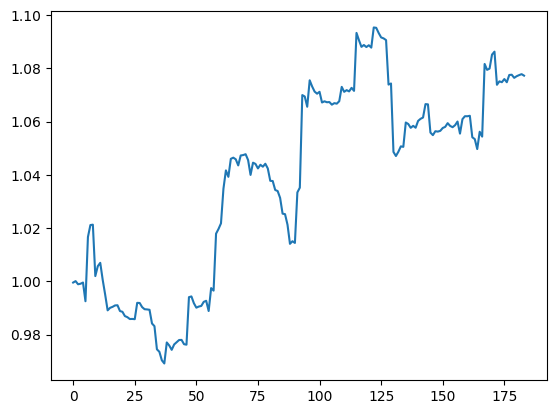

In [ ]:
# Strategy to generate Buy and sell signals
in_pos=False
buy_signal=[]
sell_signal=[]
profits=[]
for i in range(df.shape[0]):
    if df.iloc[i]["close"] < df.iloc[i]["LB"] and df["EMAF"].iloc[i]>df["EMAS"].iloc[i] and not in_pos:
        buy_price=df.iloc[i]["price"]
        buy_signal.append(df.iloc[i]["price"])
        sell_signal.append(float('nan'))
        in_pos=True
    elif (df.iloc[i]["close"] > df.iloc[i]["UB"] and df["EMAF"].iloc[i]<df["EMAS"].iloc[i] and in_pos):
        profits.append((df.iloc[i]["price"]-buy_price)/buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float('nan'))
        in_pos=False
    elif i==df.shape[0]-1 and in_pos:
        profits.append((df.iloc[i]["price"]-buy_price)/buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float('nan'))
        in_pos=False
    else:
        sell_signal.append(float('nan'))
        buy_signal.append(float('nan'))
print("No:of Trades:",len(profits))
(pd.Series(profits) +1).cumprod().plot()

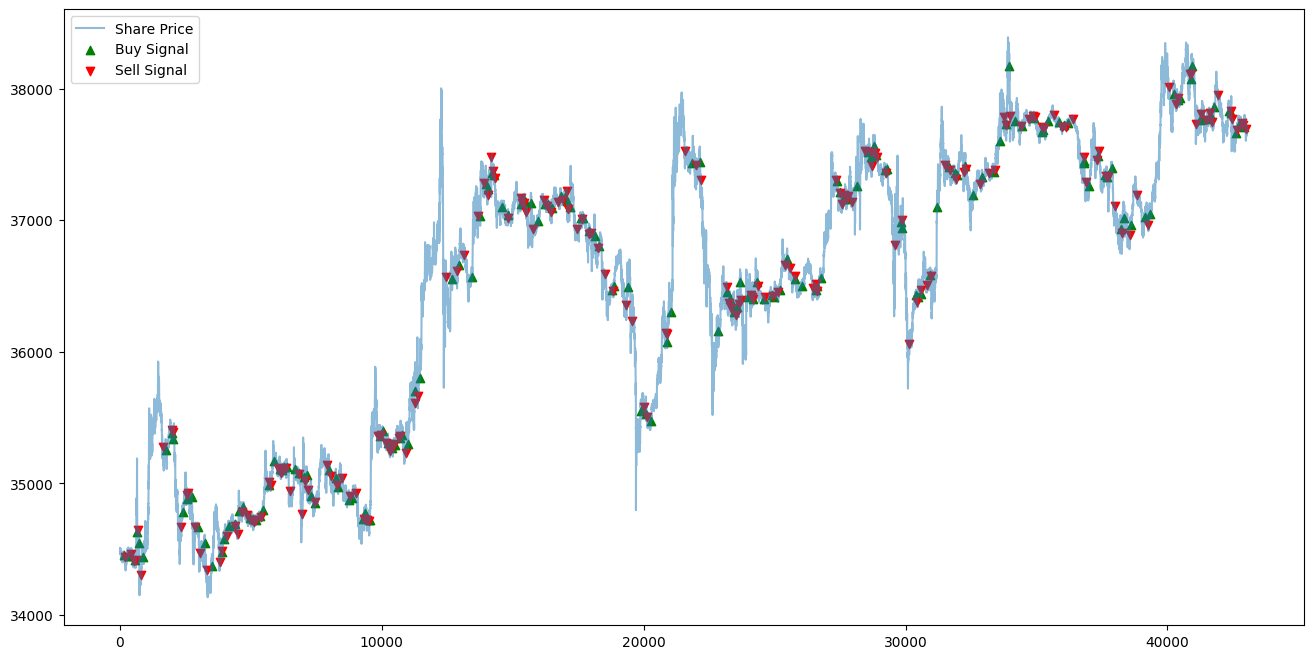

In [ ]:
plt.figure(figsize=(16,8))
df['buy_signal']=buy_signal
df['sell_signal']=sell_signal
plt.plot(df['close'],label='Share Price',alpha=0.5)
# plt.plot(df["EMAF"], label='Short-Term MA (20)')
# plt.plot(df["EMAS"], label='Long-Term MA (150)')
plt.scatter(df.index, df['buy_signal'], label='Buy Signal',  marker='^',color='green')
plt.scatter(df.index, df['sell_signal'], label='Sell Signal', marker='v',color='red')
plt.legend()
plt.show()

In [ ]:
profits = np.array(profits)
Winning_trades=sum(profit > 0 for profit in profits)
print("Total no:of Trades:", len(profits))
print("No:of Winning Trades:",Winning_trades )
print("No:of Losing Trades:", len(profits)-Winning_trades)
print("Success rate: {:.4f}%" .format(Winning_trades/len(profits)*100))
print("Cumulative Return: {:.4f}%" .format((np.prod(1 + profits) - 1)*100))
df_ret = pd.DataFrame({"ret": profits})
print("Volatility: {:.4f}%" .format(volatility(df_ret)))
print("Max Drawdown: {:.4f}%" .format(max_dd(df_ret)))

Total no:of Trades: 184
No:of Winning Trades: 87
No:of Losing Trades: 97
Success rate: 47.2826%
Cumulative Return: 7.7283%
Volatility: 0.6136%
Max Drawdown: 5.1073%


The results shows the above strategy has high volatility, high drawdown and lesser profitable trades but it managed to find highly profitable trades and better returns, the flaws may be rectified by using a suitable stop loss and target price

**Trading Strategy - 4 Using Volume averages and BB**

No:of Trades: 300


<Axes: >

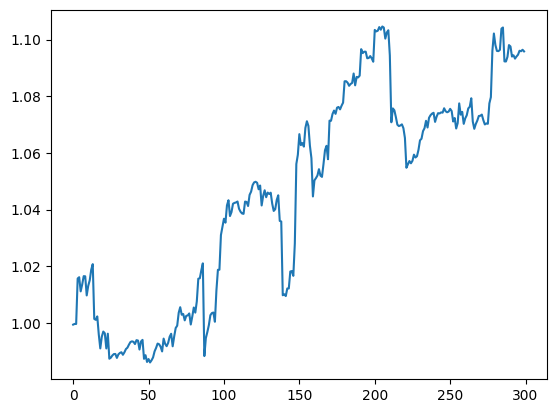

In [ ]:
in_pos = False
buy_signal = []
sell_signal = []
profits = []
for i in range(df.shape[0]):
    if ((df["volume_10ma"].iloc[i] > df["volume_30ma"].iloc[i])
        and (df.iloc[i]["close"] < df.iloc[i]["LB"])
        and not in_pos
    ):
        buy_price = df.iloc[i]["price"]
        buy_signal.append(df.iloc[i]["price"])
        sell_signal.append(float("nan"))
        in_pos = True
    elif ((df["volume_10ma"].iloc[i] < df["volume_30ma"].iloc[i])
         and (df.iloc[i]["close"] > df.iloc[i]["UB"])
         and in_pos
    ):
        profits.append((df.iloc[i]["price"] - buy_price) / buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float("nan"))
        in_pos = False
    elif i == df.shape[0] - 1 and in_pos:
        profits.append((df.iloc[i]["price"] - buy_price) / buy_price)
        sell_signal.append(df.iloc[i]["price"])
        buy_signal.append(float("nan"))
        in_pos = False
    else:
        sell_signal.append(float("nan"))
        buy_signal.append(float("nan"))

print("No:of Trades:", len(profits))
(pd.Series(profits) + 1).cumprod().plot()

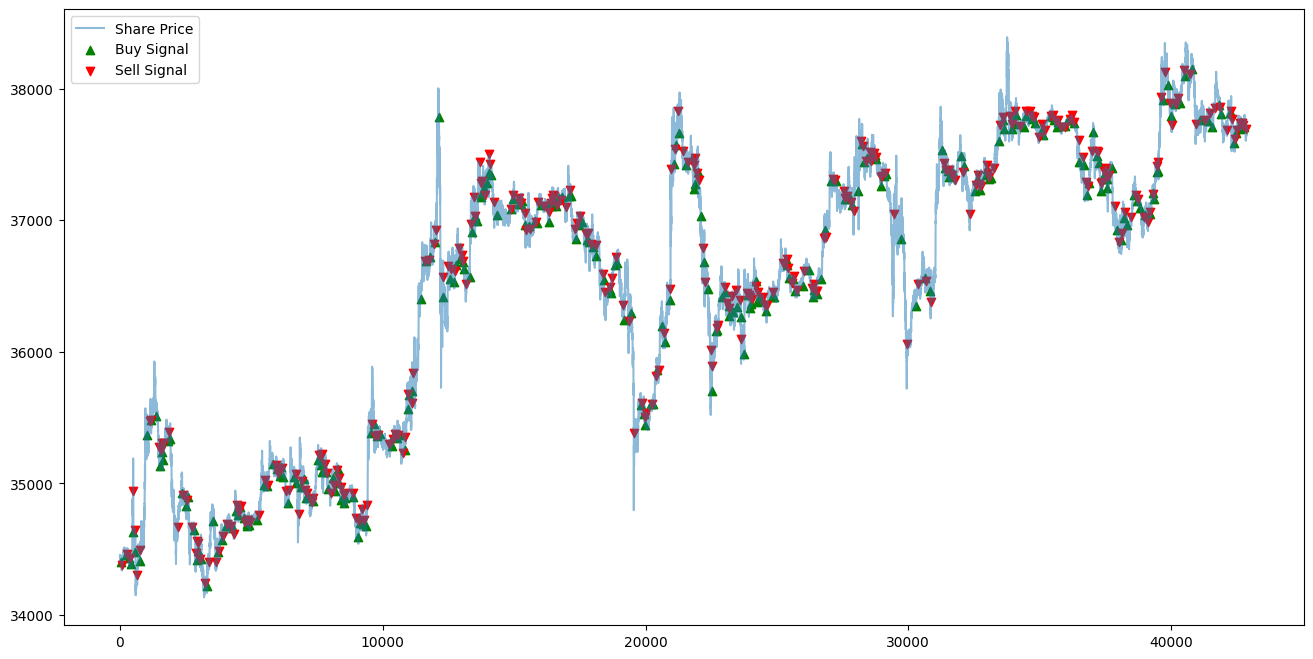

In [ ]:
plt.figure(figsize=(16,8))
df['buy_signal']=buy_signal
df['sell_signal']=sell_signal
plt.plot(df['close'],label='Share Price',alpha=0.5)
# plt.plot(df["EMAF"], label='Short-Term MA (20)')
# plt.plot(df["EMAS"], label='Long-Term MA (150)')
plt.scatter(df.index, df['buy_signal'], label='Buy Signal',  marker='^',color='green')
plt.scatter(df.index, df['sell_signal'], label='Sell Signal', marker='v',color='red')
plt.legend()
plt.show()

In [ ]:
profits = np.array(profits)
Winning_trades=sum(profit > 0 for profit in profits)
print("Total no:of Trades:", len(profits))
print("No:of Winning Trades:",Winning_trades )
print("No:of Losing Trades:", len(profits)-Winning_trades)
print("Success rate: {:.4f}%" .format(Winning_trades/len(profits)*100))
print("Cumulative Return: {:.4f}%" .format((np.prod(1 + profits) - 1)*100))
df_ret = pd.DataFrame({"ret": profits})
print("Volatility: {:.4f}%" .format(volatility(df_ret)))
print("Max Drawdown: {:.4f}%" .format(max_dd(df_ret)))

Total no:of Trades: 300
No:of Winning Trades: 185
No:of Losing Trades: 115
Success rate: 61.6667%
Cumulative Return: 9.5836%
Volatility: 0.4812%
Max Drawdown: 4.5124%


The results shows this strategy is relatively less volatile and has a better winning percent and good returns.